JOBSHEET 03:  
TEKNIK REGRESI GAMBAR 


Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran) 

Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace) 

In [1]:
pip install kaggle

  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
Using cached bleach-6.2.0-py3-none-any.whl (163 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!kaggle datasets download -d jangedoo/utkface-new -p "F:\Documents\Coding\Kuliah\SMT 3\Visi Komputer\Visi_Komputer_TI-2A_05\Jobsheet 3"

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors




  0%|          | 0.00/331M [00:00<?, ?B/s]
 41%|████▏     | 137M/331M [00:00<00:00, 1.44GB/s]
 83%|████████▎ | 275M/331M [00:00<00:00, 1.44GB/s]
100%|██████████| 331M/331M [00:00<00:00, 1.45GB/s]


f:\Documents\Coding\Kuliah\SMT 3\Visi Komputer\Visi_Komputer_TI-2A_05\Jobsheet 3


Total gambar ditemukan: 23708


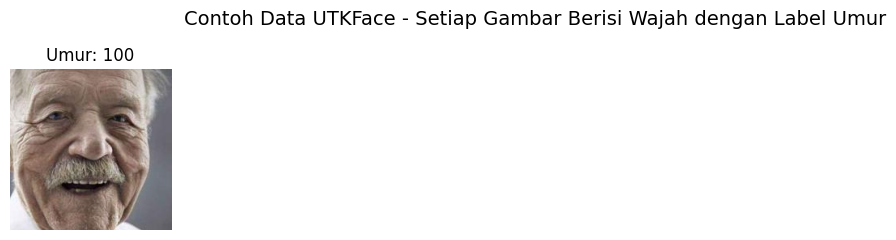

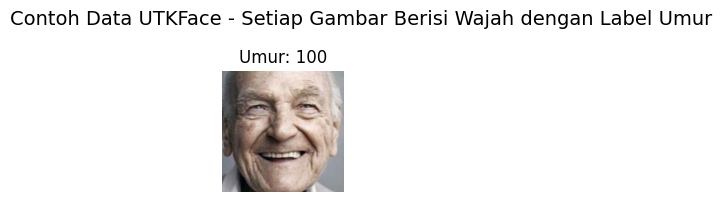

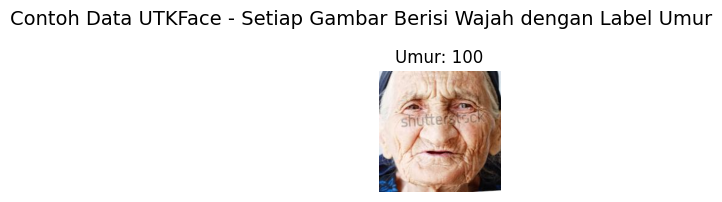

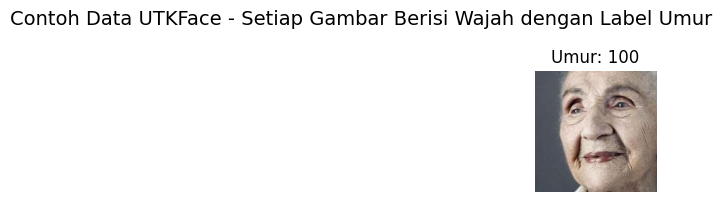

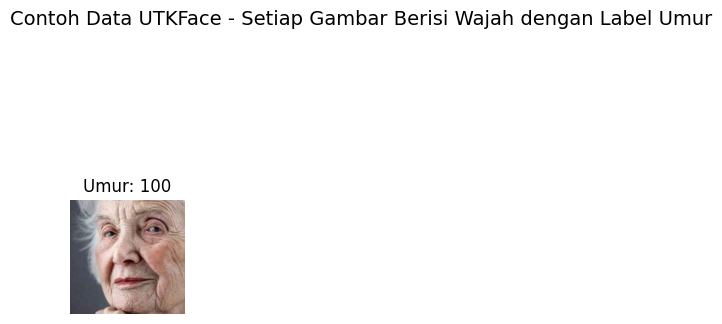

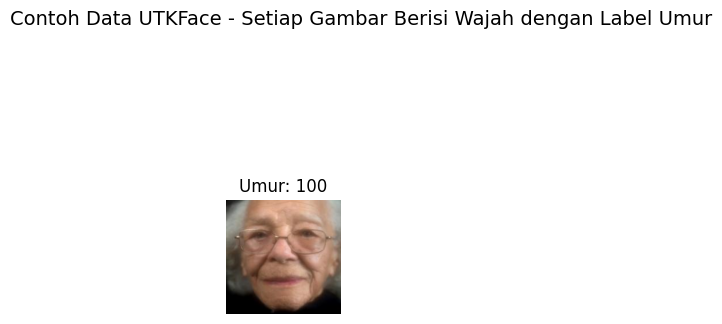

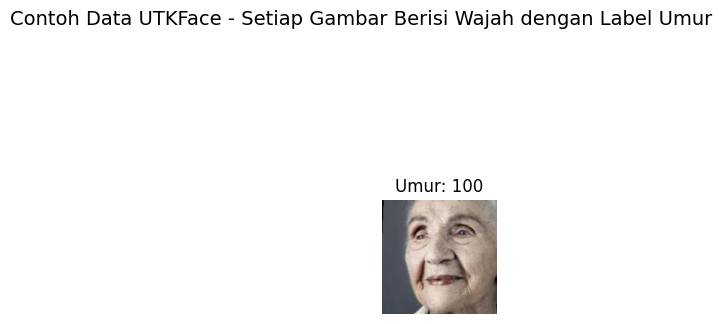

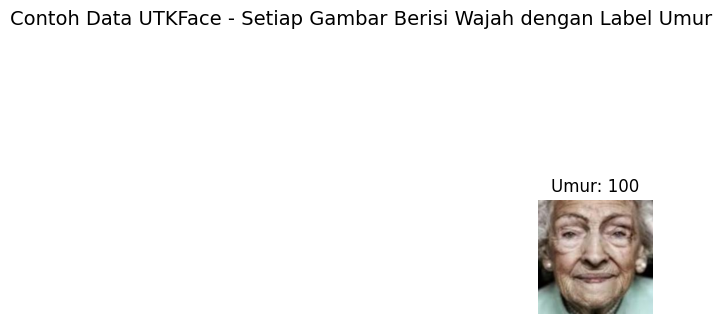

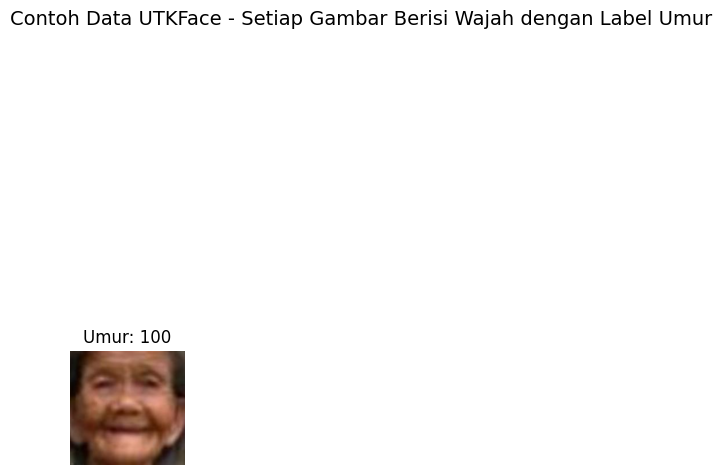

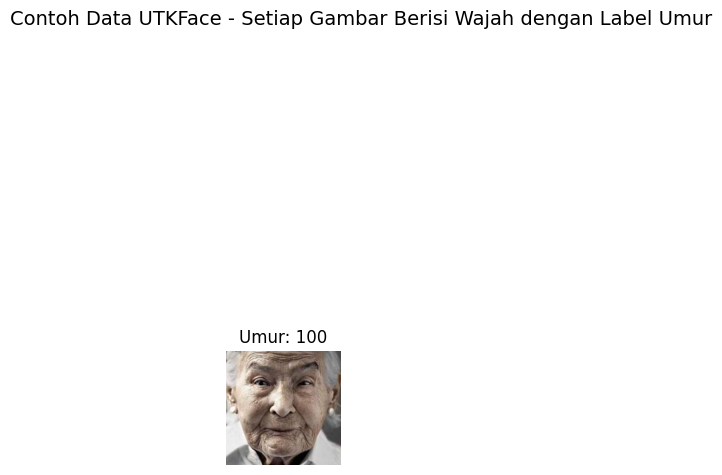

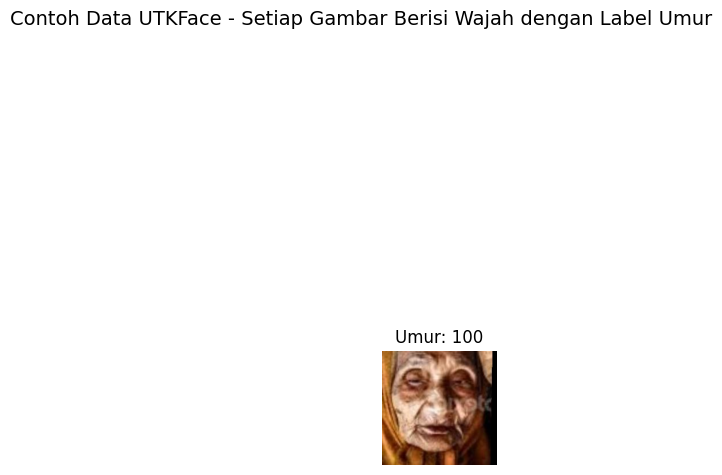

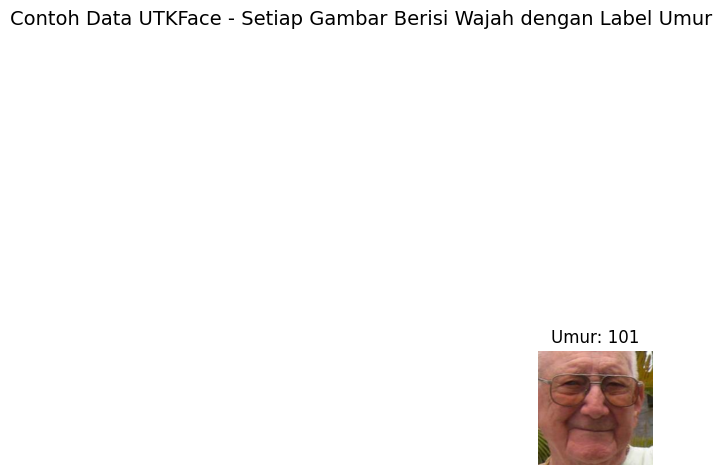

In [11]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

files = glob.glob("UTKFace/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
   age = int(os.path.basename(f).split("_")[0])
   img = Image.open(f)
   plt.subplot(3, 4, i + 1)
   plt.imshow(img)
   plt.title(f"Umur: {age}")
   plt.axis("off")
   plt.suptitle("Contoh Data UTKFace - Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
   plt.tight_layout()
   plt.show()

In [19]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
   return int(os.path.basename(fp).split('_')[0])
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
   img = tf.io.read_file(fp)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
   return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)
print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


In [22]:
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score

print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else  "CPU") 

base_model = tf.keras.applications.MobileNetV2(
   include_top=False,
   input_shape=(IMG_SIZE, IMG_SIZE, 3),
   weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs*255.0) 
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128,activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='mse',metrics=['mae'])
model.summary()


Hardware: CPU


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_2 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
cb = [
   tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True,monitor='val_loss'),
   tf.keras.callbacks.ReduceLROnPlateau(patience=2,factor=0.5,min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
   train_ds,
   validation_data=test_ds,
   epochs=10,
   callbacks=cb,
   verbose=1
)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()



